In [1]:
!pip install -qU langchain_community langgraph langchain_openai neo4j-driver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


## **STEP 0. Set ENV & Graph**

- Graph DB 생성 : https://sandbox.neo4j.com/

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-proj-..."
os.environ["NEO4J_URI"] = "neo4j://..."
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

In [15]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict): # 그래프의 상태를 정의하는 클래스
    messages: Annotated[list, add_messages] # 메시지 누적
    db_outputs: list

graph_builder = StateGraph(State) # StateGraph 생성 (대화 흐름 관리)

## **STEP 1. Generate Cypher Query**

> 사용자 질문에 답변하기 위한 Cypher 쿼리문을 생성하는 노드

### **get schema**

- Cypher 쿼리문 생성에 필요한 Graph DB의 스키마 텍스트 받아오기


```
Node properties:
Movie {url: STRING, runtime: INTEGER, revenue: INTEGER, budget: INTEGER, imdbRating: FLOAT, released: STRING, countries: LIST[STRING], languages: LIST[STRING], plot: STRING, imdbVotes: INTEGER, imdbId: STRING, year: INTEGER, poster: STRING, movieId: STRING, tmdbId: STRING, title: STRING}
Genre {name: STRING}
User {userId: STRING, name: STRING}
Actor {bornIn: STRING, born: DATE, died: DATE, tmdbId: STRING, imdbId: STRING, name: STRING, url: STRING, bio: STRING, poster: STRING}
Person {bornIn: STRING, born: DATE, died: DATE, tmdbId: STRING, imdbId: STRING, name: STRING, url: STRING, bio: STRING, poster: STRING}
Director {url: STRING, bornIn: STRING, bio: STRING, died: DATE, born: DATE, imdbId: STRING, name: STRING, poster: STRING, tmdbId: STRING}

Relationship properties:
RATED {rating: FLOAT, timestamp: INTEGER}
ACTED_IN {role: STRING}
DIRECTED {role: STRING}

The relationships:
(:Actor)-[:ACTED_IN]->(:Movie)
(:Actor)-[:DIRECTED]->(:Movie)
(:Actor)-[:ACTED_IN]->(:Movie)
(:Director)-[:DIRECTED]->(:Movie)
(:Movie)-[:IN_GENRE]->(:Genre)
(:User)-[:RATED]->(:Movie)
```

In [16]:
from neo4j import GraphDatabase, basic_auth

neo4j_uri = os.environ["NEO4J_URI"]
neo4j_username = os.environ["NEO4J_USERNAME"]
neo4j_password = os.environ["NEO4J_PASSWORD"]

driver = GraphDatabase.driver(
        neo4j_uri,
        auth=basic_auth(neo4j_username, neo4j_password))

In [17]:
from neo4j.time import Date

def get_node_datatype(value):
    """
        입력된 노드 Value의 데이터 타입을 반환하는 함수
    """
    if isinstance(value, str):
        return "STRING"
    elif isinstance(value, int):
        return "INTEGER"
    elif isinstance(value, float):
        return "FLOAT"
    elif isinstance(value, bool):
        return "BOOLEAN"
    elif isinstance(value, list):
        return f"LIST[{get_node_datatype(value[0])}]" if value else "LIST"
    elif isinstance(value, Date):
        return "DATE"
    else:
        return "UNKNOWN"

def get_schema_dict():
    """
        Graph DB의 정보를 받아 노드 및 관계의 프로퍼티를 추출하고 스키마 딕셔너리를 반환하는 함수
    """
    with driver.session() as session:
        # 노드 프로퍼티 및 타입 추출
        node_query = """
        MATCH (n)
        WITH DISTINCT labels(n) AS node_labels, keys(n) AS property_keys, n
        UNWIND node_labels AS label
        UNWIND property_keys AS key
        RETURN label, key, n[key] AS sample_value
        """
        nodes = session.run(node_query)

        # 관계 프로퍼티 및 타입 추출
        rel_query = """
        MATCH ()-[r]->()
        WITH DISTINCT type(r) AS rel_type, keys(r) AS property_keys, r
        UNWIND property_keys AS key
        RETURN rel_type, key, r[key] AS sample_value
        """
        relationships = session.run(rel_query)

        # 관계 유형 및 방향 추출
        rel_direction_query = """
        MATCH (a)-[r]->(b)
        RETURN DISTINCT labels(a) AS start_label, type(r) AS rel_type, labels(b) AS end_label
        ORDER BY start_label, rel_type, end_label
        """
        rel_directions = session.run(rel_direction_query)

        # 스키마 딕셔너리 생성
        schema = {"nodes": {}, "relationships": {}, "relations": []}

        for record in nodes:
            label = record["label"]
            key = record["key"]
            sample_value = record["sample_value"] # 데이터 타입을 추론하기 위한 샘플 데이터
            inferred_type = get_node_datatype(sample_value)
            if label not in schema["nodes"]:
                schema["nodes"][label] = {}
            schema["nodes"][label][key] = inferred_type

        for record in relationships:
            rel_type = record["rel_type"]
            key = record["key"]
            sample_value = record["sample_value"] # 데이터 타입을 추론하기 위한 샘플 데이터
            inferred_type = get_node_datatype(sample_value)
            if rel_type not in schema["relationships"]:
                schema["relationships"][rel_type] = {}
            schema["relationships"][rel_type][key] = inferred_type

        for record in rel_directions:
            start_label = record["start_label"][0]
            rel_type = record["rel_type"]
            end_label = record["end_label"][0]
            schema["relations"].append(f"(:{start_label})-[:{rel_type}]->(:{end_label})")

        return schema

def get_schema_str(schema):
    """
        스키마 딕셔너리를 LLM에 제공하기 위해 원하는 형태로 formatting 하는 함수
    """
    result = []

    # 노드 프로퍼티 출력
    result.append("Node properties:")
    for label, properties in schema["nodes"].items():
        props = ", ".join(f"{k}: {v}" for k, v in properties.items())
        result.append(f"{label} {{{props}}}")

    # 관계 프로퍼티 출력
    result.append("Relationship properties:")
    for rel_type, properties in schema["relationships"].items():
        props = ", ".join(f"{k}: {v}" for k, v in properties.items())
        result.append(f"{rel_type} {{{props}}}")

    # 관계 프로퍼티 출력
    result.append("The relationships:")
    for relation in schema["relations"]:
        result.append(relation)

    return "\n".join(result)

In [18]:
schema = get_schema_str(get_schema_dict())

In [19]:
print(schema)

Node properties:
Movie {tagline: STRING, title: STRING, released: INTEGER}
Person {name: STRING, born: INTEGER}
Relationship properties:
ACTED_IN {roles: LIST[STRING]}
REVIEWED {summary: STRING, rating: INTEGER}
The relationships:
(:Person)-[:ACTED_IN]->(:Movie)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:FOLLOWS]->(:Person)
(:Person)-[:PRODUCED]->(:Movie)
(:Person)-[:REVIEWED]->(:Movie)
(:Person)-[:WROTE]->(:Movie)


### **llm for generating cypher**

- Cypher 쿼리문을 생성하는 LLM 구성하기

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [21]:
# LLM INPUT / QUERY 예시 제공
fewshot_examples = [
    "USER INPUT: 'Toy Story에 어떤 배우들이 출연하나요?' QUERY: MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) WHERE m.title = 'Toy Story' RETURN a.name",
    "USER INPUT: 'Toy Story의 평균 평점은 몇점인가요?' QUERY: MATCH (u:User)-[r:RATED]->(m:Movie) WHERE m.title = 'Toy Story' RETURN AVG(r.rating)",
]

In [22]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage

GENERATE_SYSTEM_TEMPLATE = """Given an input question, convert it to a Cypher query. No pre-amble.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"""

GENERATE_USER_TEMPLATE = """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information
{schema}

Below are a number of examples of questions and their corresponding Cypher queries.

{fewshot_examples}

User input: {question}
Cypher query:"""

def generate_cypher(state: State):
    generate_cypher_msgs = [
        ("system", GENERATE_SYSTEM_TEMPLATE),
        ("user", GENERATE_USER_TEMPLATE),
    ]
    text2cypher_prompt = ChatPromptTemplate.from_messages(generate_cypher_msgs)

    response = llm.invoke(
        text2cypher_prompt.format_messages(
            question=state["messages"], schema=schema, fewshot_examples=fewshot_examples
        )
    )
    outputs = []
    outputs.append(
        AIMessage(
            content=response.content,
        )
    )

    return {"messages": outputs}

graph_builder.add_node("generate_cypher", generate_cypher)

## **STEP 2. Excute Query**

> Query 를 Neo4j Graph DB에서 실행하는 노드

In [23]:
import json

class ExcuteCypherNode:
    """
        A node that runs the query generated in the last AIMessage.
        마지막 AIMessage에서 생성된 Cypher를 실행하는 노드
    """

    def __init__(self) -> None:
        self.driver = driver

    def __call__(self, inputs: dict):
        print("###### EXCUTE CYPHER ######")
        if messages := inputs.get("messages", []):
            message = messages[-1].content # 마지막 message
        else:
            raise ValueError("No message found in input")
        outputs = []

        print("실행 쿼리문", message)

        try:
            with driver.session(database="neo4j") as session:
                database_output = session.read_transaction(
                    lambda tx: tx.run(message).data())

        except Exception as e:
                database_output = str(e)

        outputs.append(
            database_output
        )
        return {"db_outputs": outputs}

excute_cypher_node = ExcuteCypherNode()
graph_builder.add_node("excute_cypher", excute_cypher_node)

## **STEP 2-1. Router Edge**

> Cypher가 정상 실행되어 조회되었는 지 확인하고 조회 실패했다면 Cypher 수정하는 노드로 보내는 엣지

In [24]:
def route_correction(
    state: State,
):
    """
    A edge that route to the "correct_cypher" node if the last generated Cypher query was not executed properly.
    마지막으로 생성된 Cypher 쿼리가 제대로 실행되지 않은 경우 "correct_cypher" 노드로 라우팅되는 엣지
    """
    if db_outputs := state.get("db_outputs", []):
        db_result = db_outputs[-1]
    else:
        raise ValueError(f"No DB result found")

    print("###### ROUTE QUERY CORRECTION ######")
    print("DB 조회 결과", db_result)
    if type(db_result) == list and len(db_result) > 0: # 실행 성공 조건 : DB 조회 결과가 길이가 1이상인 리스트
        print("!정상 조회 완료!")
        return "answer"

    print("!정상 조회 실패!")
    return "correct_cypher"

# 조건부 엣지 연결
graph_builder.add_conditional_edges(
    "excute_cypher", # 시작 노드
    route_correction,
    {"correct_cypher": "correct_cypher", "answer": "answer"},
)

## **STEP 3. Correct Query**

> DB 조회 실패 시 생성되었던 Cypher 쿼리문 수정하는 노드

In [25]:
CORRECT_CYPHER_SYSTEM_TEMPLATE = """You are a Cypher expert reviewing a statement written by a junior developer.
You need to correct the Cypher statement based on the provided errors. No pre-amble."
If the error is empty, return "RETURN "No search results found." AS result;".
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"""

CORRECT_CYPHER_USER_TEMPLATE = """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """

def correct_cypher(state: State):
    if messages := state.get("db_outputs", []):
        db_result = messages[-1]
    else:
        raise ValueError(f"No DB result found")

    if messages := state.get("messages", []):
        cypher = messages[-1].content
    else:
        raise ValueError(f"No Cypher found")

    print("###### CORRECT CYPHER ######")
    print("수정 전 쿼리문", cypher)
    print("DB 조회 결과", db_result)

    correct_cypher_messages = [
        ("system", CORRECT_CYPHER_SYSTEM_TEMPLATE),
        ("user", CORRECT_CYPHER_USER_TEMPLATE),
    ]
    correct_cypher_prompt = ChatPromptTemplate.from_messages(correct_cypher_messages)

    response = llm.invoke(
        correct_cypher_prompt.format_messages(
            question=state["messages"], schema=schema, cypher=cypher, errors=db_result
        )
    )

    outputs = []
    outputs.append(
        AIMessage(
            content=response.content,
        )
    )

    print("수정 후 쿼리문", response.content)
    return {"messages": outputs}

graph_builder.add_node("correct_cypher", correct_cypher)

### error & correct example

In [29]:
# a와 m을 지칭하는 게 없음 / 오류나는 쿼리
cypher_example = "MATCH (Actor)-[:ACTED_IN]->(Movie) WHERE a.name = 'Tom Hanks' RETURN m.title LIMIT 3"

In [30]:
try:
    with driver.session(database="neo4j") as session:
        results = session.read_transaction(
            lambda tx: tx.run(cypher_example).data())

except Exception as e:
    errors_example = str(e)

/tmp/ipython-input-3861916047.py:3: DeprecationWarning: read_transaction has been renamed to execute_read
  results = session.read_transaction(


In [31]:
errors_example

'{code: Neo.ClientError.Statement.SyntaxError} {message: Variable `a` not defined (line 1, column 42 (offset: 41))\n"MATCH (Actor)-[:ACTED_IN]->(Movie) WHERE a.name = \'Tom Hanks\' RETURN m.title LIMIT 3"\n                                          ^}'

In [32]:
correct_cypher_messages = [
    ("system", CORRECT_CYPHER_SYSTEM_TEMPLATE),
    ("user", CORRECT_CYPHER_USER_TEMPLATE),
]
correct_cypher_prompt = ChatPromptTemplate.from_messages(correct_cypher_messages)

response = llm.invoke(
    correct_cypher_prompt.format_messages(
        question="Tom Hanks 가 출연한 영화", schema=schema, cypher=cypher_example, errors=errors_example
    )
)

In [33]:
print(response.content)

MATCH (a:Person)-[:ACTED_IN]->(m:Movie) WHERE a.name = 'Tom Hanks' RETURN m.title LIMIT 3


## **STEP 4. Answer based DB Results**

> 사용자 질문, Cypher 쿼리문, DB 조회 결과를 기반으로 답변하는 노드

In [34]:
FINAL_ANSWER_SYSTEM_TEMPLATE = """
You are a highly intelligent assistant trained to provide concise and accurate answers.
You will be given a context that has been retrieved from a Neo4j database using a specific Cypher query.
Your task is to analyze the context and answer the user’s question based on the information provided in the context.
If the context lacks sufficient information, inform the user and suggest what additional details are needed.

Focus solely on the context provided from the Neo4j database to form your response.
Avoid making assumptions or using external knowledge unless explicitly stated in the context.
Ensure the final answer is clear, relevant, and directly addresses the user’s question.
If the question is ambiguous, ask clarifying questions to ensure accuracy before proceeding.
ANSWER IN KOREAN.
"""

FINAL_ANSWER_USER_TEMPLATE = """
Based on this context retrieved from a Neo4j database using the following Cypher query:
`{cypher_query}`

The context is:
{context}

Answer the following question:
<question>
{question}
</question>

Please provide your answer based on the context above, explaining your reasoning.
If clarification or additional information is needed, explain why and specify what is required.
"""


def answer(state: State):
    if messages := state.get("db_outputs", []):
        db_result = messages[-1]
    else:
        raise ValueError(f"No DB result found")

    if messages := state.get("messages", []):
        cypher = messages[-1].content
    else:
        raise ValueError(f"No Cypher found")

    final_answer_msgs = [
        ("system", FINAL_ANSWER_SYSTEM_TEMPLATE),
        ("user", FINAL_ANSWER_USER_TEMPLATE),
    ]
    final_answer_prompt = ChatPromptTemplate.from_messages(final_answer_msgs)

    response = llm.invoke(
        final_answer_prompt.format_messages(
            cypher_query=cypher, context=db_result, question=state["messages"]
        )
    )

    outputs = []
    outputs.append(
        AIMessage(
            content=response.content,
        )
    )

    print("###### ANSWER BASED DB RESULT ######")
    print("최종 답변", response.content)

    return {"messages": outputs}

graph_builder.add_node("answer", answer)

## **STEP 5. Compile Graph**

In [35]:
# 엣지 연결
graph_builder.add_edge(START, "generate_cypher")
graph_builder.add_edge("generate_cypher", "excute_cypher")
graph_builder.add_edge("correct_cypher", "excute_cypher")
graph_builder.add_edge("answer", END)
graph = graph_builder.compile()

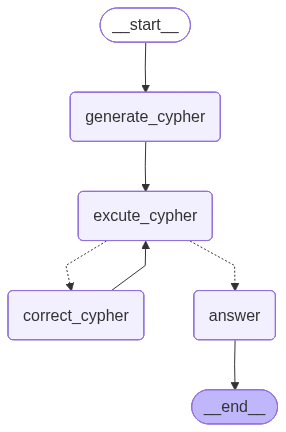

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}): # graph 노드 호출 결과 받아옴
        for value in event.values():
            print(value, "\n")

In [ ]:
while True:
    try:
        user_input = input("🧑‍💻 User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        break

🧑‍💻 User: jwg
{'messages': [AIMessage(content="MATCH (m:Movie {title: 'jwg'}) RETURN m", additional_kwargs={}, response_metadata={}, id='904f34da-4a16-4bff-82f6-5908154a6d29', tool_calls=[], invalid_tool_calls=[])]} 

###### EXCUTE CYPHER ######
실행 쿼리문 MATCH (m:Movie {title: 'jwg'}) RETURN m


/tmp/ipython-input-1483124479.py:24: DeprecationWarning: read_transaction has been renamed to execute_read
  database_output = session.read_transaction(


###### ROUTE QUERY CORRECTION ######
DB 조회 결과 []
!정상 조회 실패!
{'db_outputs': [[]]} 

###### CORRECT CYPHER ######
수정 전 쿼리문 MATCH (m:Movie {title: 'jwg'}) RETURN m
DB 조회 결과 []
수정 후 쿼리문 RETURN "No search results found." AS result;
{'messages': [AIMessage(content='RETURN "No search results found." AS result;', additional_kwargs={}, response_metadata={}, id='67e34fd4-90fd-49c5-b0fe-10ca8c09cbf7', tool_calls=[], invalid_tool_calls=[])]} 

###### EXCUTE CYPHER ######
실행 쿼리문 RETURN "No search results found." AS result;
###### ROUTE QUERY CORRECTION ######
DB 조회 결과 [{'result': 'No search results found.'}]
!정상 조회 완료!
{'db_outputs': [[{'result': 'No search results found.'}]]} 

###### ANSWER BASED DB RESULT ######
최종 답변 검색 결과가 없습니다. 질문에서 언급된 'jwg'라는 제목의 영화를 데이터베이스에서 찾을 수 없다는 의미입니다. 추가적인 정보를 원하신다면, 영화에 대한 다른 세부사항이나 데이터베이스에서의 다른 검색 기준이 필요합니다. 예를 들어, 영화의 감독, 출시 연도 등을 제공해 주시면 더 정확한 검색에 도움이 될 것입니다.
{'messages': [AIMessage(content="검색 결과가 없습니다. 질문에서 언급된 'jwg'라는 제목의 영화를 데이터베이스에서 찾을 수 없다는 의미입니다. 추가적인 정보를 

###### ROUTE QUERY CORRECTION ######
DB 조회 결과 []
!정상 조회 실패!
{'db_outputs': [[]]} 

###### CORRECT CYPHER ######
수정 전 쿼리문 MATCH (p:Person)-[:DIRECTED]->(m:Movie)-[:IN_GENRE]->(g:Genre) WHERE p.name = '봉준호' RETURN DISTINCT g.name
DB 조회 결과 []
수정 후 쿼리문 RETURN "No search results found." AS result;
{'messages': [AIMessage(content='RETURN "No search results found." AS result;', additional_kwargs={}, response_metadata={}, id='05b1d0fc-5d6d-450d-b8c6-6a29a1af581a', tool_calls=[], invalid_tool_calls=[])]} 

###### EXCUTE CYPHER ######
실행 쿼리문 RETURN "No search results found." AS result;
###### ROUTE QUERY CORRECTION ######
DB 조회 결과 [{'result': 'No search results found.'}]
!정상 조회 완료!
{'db_outputs': [[{'result': 'No search results found.'}]]} 

###### ANSWER BASED DB RESULT ######
최종 답변 제공된 문맥에 따르면, "No search results found."라는 결과만 있을 뿐, 봉준호 감독이 만든 영화의 장르에 대한 정보는 제공되지 않았습니다. 따라서, 추가적인 정보가 필요합니다. 특히, 봉준호 감독과 관련된 데이터베이스 정보나 그의 작품 장르에 대한 정보를 가진 데이터베이스가 있으면 좋겠습니다.
{'messages': [AIMessage(content='제공된 문

###### ROUTE QUERY CORRECTION ######
DB 조회 결과 []
!정상 조회 실패!
{'db_outputs': [[]]} 

###### CORRECT CYPHER ######
수정 전 쿼리문 MATCH (p:Person)-[:DIRECTED]->(m:Movie)<-[:IN_GENRE]-(g:Genre) 
WHERE p.name = 'Steven Spielberg' 
RETURN DISTINCT g.name
DB 조회 결과 []
수정 후 쿼리문 RETURN "No search results found." AS result;
{'messages': [AIMessage(content='RETURN "No search results found." AS result;', additional_kwargs={}, response_metadata={}, id='6a5d8d33-87a7-4bfe-8250-e483e3c9a35f', tool_calls=[], invalid_tool_calls=[])]} 

###### EXCUTE CYPHER ######
실행 쿼리문 RETURN "No search results found." AS result;
###### ROUTE QUERY CORRECTION ######
DB 조회 결과 [{'result': 'No search results found.'}]
!정상 조회 완료!
{'db_outputs': [[{'result': 'No search results found.'}]]} 

###### ANSWER BASED DB RESULT ######
최종 답변 질문에 대한 정보는 Neo4j 데이터베이스에서 검색된 결과가 없다는 내용만 제공되었습니다. 따라서 Steven Spielberg 감독이 어떤 장르의 영화를 만들었는지에 대한 정보를 제공할 수 없습니다.

추가적인 세부 정보가 필요합니다. 예를 들어, Neo4j 데이터베이스에 Steven Spielberg와 관련된 영화 감독 정보가 존재하는지, 그리고 그와 